In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('manual_label_candidates.csv', sep=';')
df.head(10)

,image,row_idx,row_ratio,text,label
0,X51005441401.jpg,7,0.333,BIZDATE: 12/03/2018,0
1,X51007339146.jpg,24,0.727,SR @ 6% 15.57 0.93,0
2,X51005301667.jpg,7,0.130,CREDIT NOTE,0
3,X51005745187.jpg,13,0.481,3557366100208 •- 21.20 2120 SR,0
4,X51006388044.jpg,5,0.263,400002 1.00 X 21.32 21.32,0
5,X51008123476.jpg,0,0.000,Dion Realties Sdn Bhd (Ca. No:20154-T),0
6,X51008030566.jpg,13,0.481,1 x 2.20 2.20 SR,0
7,X51007846357.jpg,25,0.385,1x 7.80,0
8,X51005742068.jpg,12,0.750,PPF P1 1.000 6 6.00,0
9,X51006912972.jpg,43,0.662,0.46,0


In [3]:
df["label"].value_counts()

label
0    1695
1     305
Name: count, dtype: int64

### **Layout**

In [4]:
df["row_ratio"] = df["row_ratio"].astype(float)

### **Lexical**

In [5]:
df["word_count"] = df["text"].apply(lambda s: len([w for w in s.split() if w.isalpha()]))

In [6]:
def digit_ratio(text):
    return sum(c.isdigit() for c in text) / max(len(text), 1)

df["digit_ratio"] = df["text"].apply(digit_ratio)

In [7]:
df["starts_alpha"] = df["text"].apply(lambda s: int(len(s) > 0 and s[0].isalpha()))

### **Price Structure**

In [8]:
df["price_count"] = df["text"].str.findall(r"\d+\.\d{2}").apply(len)

In [9]:
df["price_at_end"] = df["text"].apply(
    lambda s: int(bool(re.search(r"\d+\.\d{2}\s*$", s)))
)

In [10]:
df["ends_with_price_strict"] = df["text"].str.strip().str.match(r".*\d+\.\d{2}$").astype(int)

In [11]:
df["multi_price"] = df["price_count"].apply(lambda x: int(x >= 2))

In [12]:
df["has_qty_pattern"] = df["text"].str.contains(r"\b\d+\s*[xX@]\s*\d+(\.\d{2})?",regex=True).astype(int)


C:\Users\user\AppData\Local\Temp\ipykernel_15420\1820197844.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_qty_pattern"] = df["text"].str.contains(r"\b\d+\s*[xX@]\s*\d+(\.\d{2})?",regex=True).astype(int)


### **Semantic Control**

In [13]:
df["has_blacklist"] = df["text"].str.lower().apply(
    lambda t: int(any(k in t for k in [
        "total","subtotal","cash","change","tax","gst",
        "visa","master","paid","balance"
    ]))
)

In [14]:
ITEM_HINT_WORDS = [
    "pcs", "pack", "kg", "g", "ltr", "ml", "x"
]

df["has_item_hint"] = df["text"].str.lower().apply(
    lambda s: int(any(w in s for w in ITEM_HINT_WORDS))
)

In [15]:
SUMMARY_KW = [
    "total", "subtotal", "tax", "gst", "cash",
    "change", "rounding", "amount", "balance", "paid"
]

df["has_summary_keyword"] = df["text"].str.lower().apply(lambda t: int(any(k in t for k in SUMMARY_KW)))

In [16]:
FEATURES_FINAL = [
    # layout
    "row_ratio",

    # lexical
    "word_count",
    "digit_ratio",
    "starts_alpha",

    # price structure
    "price_count",
    "price_at_end",
    "ends_with_price_strict",
    "multi_price",
    "has_qty_pattern",

    # semantic control
    "has_blacklist",
    "has_item_hint",
    "has_summary_keyword"
]

X = df[FEATURES_FINAL]
y = df["label"]

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [18]:
print("Train:", y_train.value_counts(normalize=True))
print("Val:", y_val.value_counts(normalize=True))
print("Test:", y_test.value_counts(normalize=True))

Train: label
0    0.847143
1    0.152857
Name: proportion, dtype: float64
Val: label
0    0.85
1    0.15
Name: proportion, dtype: float64
Test: label
0    0.846667
1    0.153333
Name: proportion, dtype: float64


In [19]:
X_train.assign(label=y_train).to_csv("train.csv", index=False)
X_val.assign(label=y_val).to_csv("val.csv", index=False)
X_test.assign(label=y_test).to_csv("test.csv", index=False)

In [20]:
lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train, y_train)

y_val_pred = lr.predict(X_val)
print("VALIDATION")
print(classification_report(y_val, y_val_pred, digits=3))

y_test_pred = lr.predict(X_test)
print("TEST")
print(classification_report(y_test, y_test_pred, digits=3))

VALIDATION
              precision    recall  f1-score   support

           0      0.928     0.557     0.696       255
           1      0.231     0.756     0.354        45

    accuracy                          0.587       300
   macro avg      0.580     0.656     0.525       300
weighted avg      0.824     0.587     0.645       300

TEST
              precision    recall  f1-score   support

           0      0.907     0.614     0.732       254
           1      0.234     0.652     0.345        46

    accuracy                          0.620       300
   macro avg      0.571     0.633     0.539       300
weighted avg      0.804     0.620     0.673       300



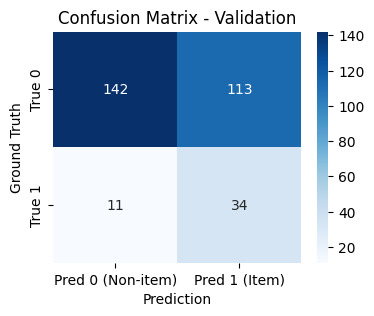

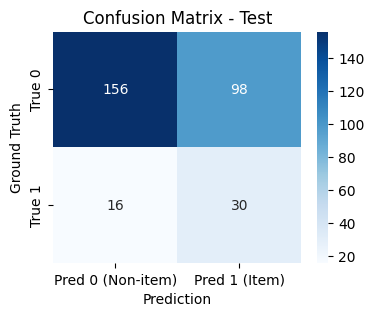

In [21]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred 0 (Non-item)", "Pred 1 (Item)"],
        yticklabels=["True 0", "True 1"]
    )
    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")
    plt.title(title)
    plt.show()

plot_cm(y_val, y_val_pred, "Confusion Matrix - Validation")
plot_cm(y_test, y_test_pred, "Confusion Matrix - Test")